Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4

## Assignment

- [ ] Watch Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Do one-hot encoding. For example, in addition to `quantity`, you could try `basin`, `extraction_type_class`, and more. (But remember it may not work with high cardinality categoricals.)
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your coefficients.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.


## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- [ ] Make exploratory visualizations.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

To visualize this dataset, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from the previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

#### Pipelines

[Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/compose.html) explains why pipelines are useful, and demonstrates how to use them:

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Reading
- [ ] [Why is logistic regression considered a linear model?](https://www.quora.com/Why-is-logistic-regression-considered-a-linear-model)
- [ ] [Training, Validation, and Testing Data Sets](https://end-to-end-machine-learning.teachable.com/blog/146320/training-validation-testing-data-sets)
- [ ] [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [ ] [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- [ ] [Statistical Modeling: The Two Cultures](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).



In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [0]:
#combining train features and train labels for plotting
df = train_features.merge(train_labels,on='id')
#creating a new status to help in plotting of categorical columns
df['status']=df['status_group'].replace({'functional':1,'non functional':2,'functional needs repair':3})

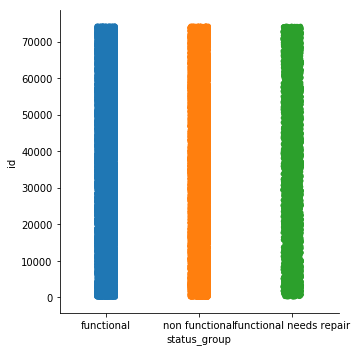

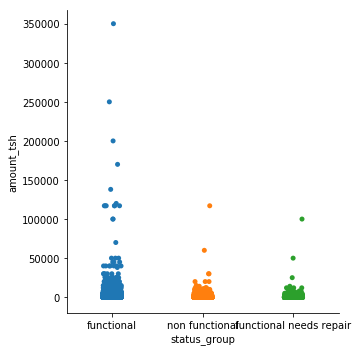

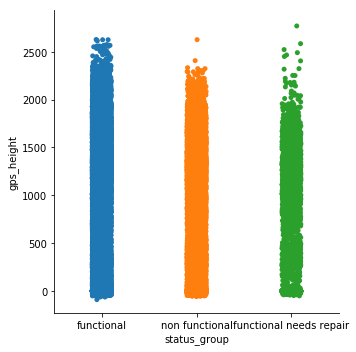

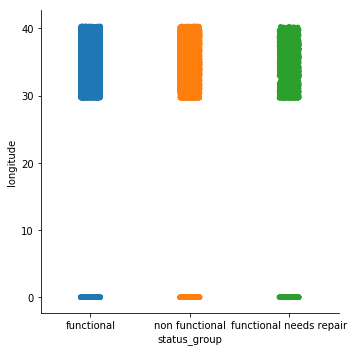

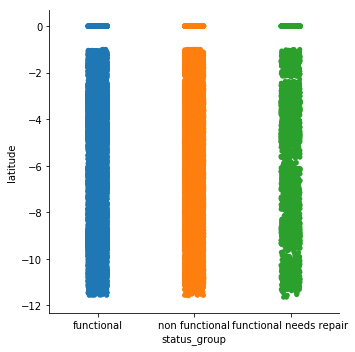

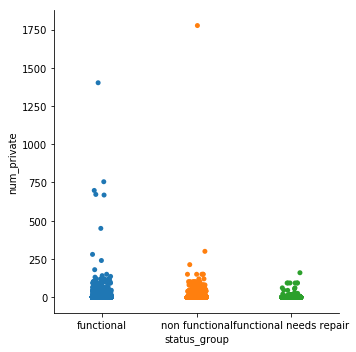

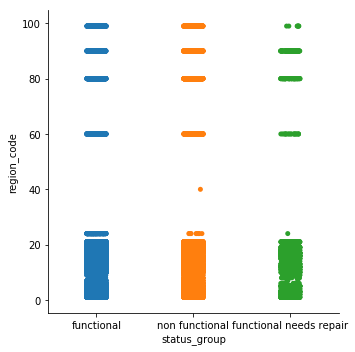

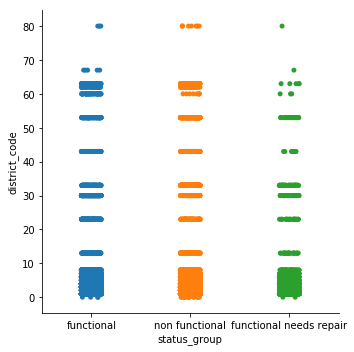

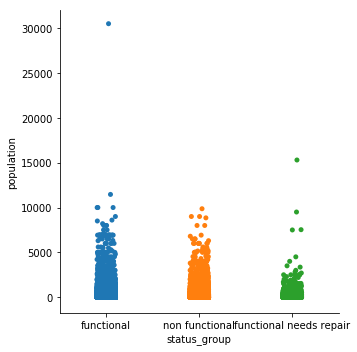

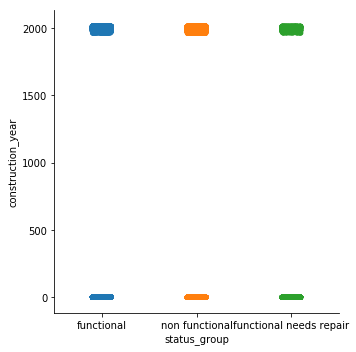

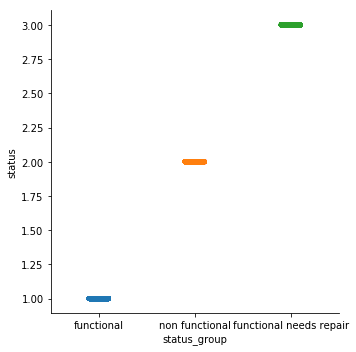

In [79]:
for col in df.select_dtypes(include='number'):
  sns.catplot(x='status_group',y=col,data=df)
  plt.show()

In [81]:
for col in df.select_dtypes(exclude='number'):
  sns.catplot(y='status',x=col,data=df)
  plt.show()

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fceeffb7d08> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest
import category_encoders as ce
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score


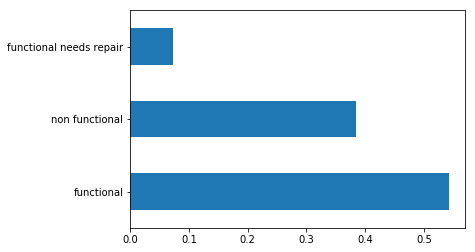

In [9]:
#Plotting the functional status of the train labels
train_labels.status_group.value_counts(normalize=True).plot(kind='barh');

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(train_features,train_labels,test_size=0.20,stratify=train_labels['status_group'])

In [0]:
cat_features = ['extraction_type_class','management_group','quality_group','quantity','source_class','water_quality','waterpoint_type_group']
num_features = train_features.select_dtypes(include='number').columns.drop('id').tolist()
features = cat_features+num_features
target = 'status_group'

In [102]:
#Code for Feature Selection, scaling and model prediction
#Encoding Cardinal Columns
encoder = ce.OneHotEncoder(use_cat_names=True,handle_missing=False,handle_unknown='error')
X_train_encoded = encoder.fit_transform(X_train[features])
X_test_encoded = encoder.transform(X_test[features])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
# X_train_scaled = (X_train_encoded)
# X_test_scaled = (X_test_encoded)
model = LogisticRegressionCV(cv=10,multi_class='multinomial')
model.fit(X_train_scaled,Y_train[target])
y_pred = model.predict(X_test_scaled)
accuracy_score(Y_test[target],y_pred)

0.6995791245791246

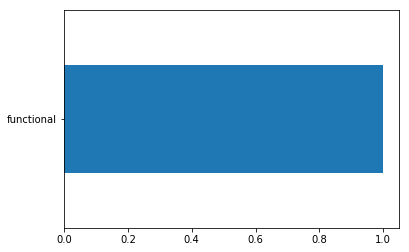

In [14]:
#sample submission before prediction
sample_submission.status_group.value_counts(normalize=True).plot(kind='barh');

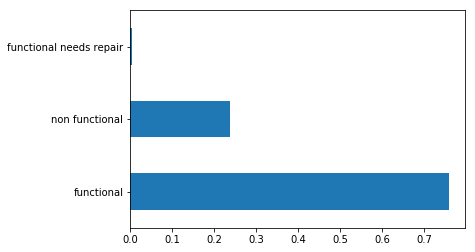

In [95]:
#Preparing the submission file
test_encoded = encoder.transform(test_features[features])
test_scaled = scaler.transform(test_encoded)
test_predictions = model.predict(test_scaled)
sample_submission['status_group']=test_predictions
#sample submission before prediction
sample_submission.status_group.value_counts(normalize=True).plot(kind='barh');

In [0]:
#preparing the csv file for submission
sample_submission.to_csv('kaggle-submission-filename.csv', index=False)

In [0]:
#Making the dataframe and Plotting the Model coefficients
model_coefficients = pd.DataFrame(dict(zip(train_labels['status_group'].unique().tolist(),model.coef_)),index=np.array(test_encoded.columns))


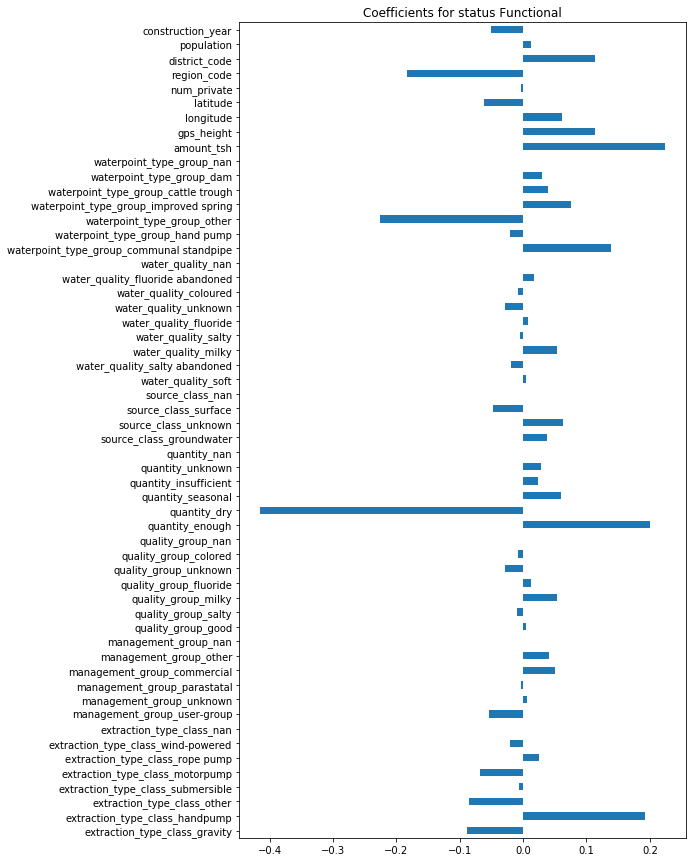

In [97]:
#Model Coefficients plotting for status functional
fig = plt.figure(figsize=(8,15))
model_coefficients['functional'].plot(kind='barh');
plt.title("Coefficients for status Functional");

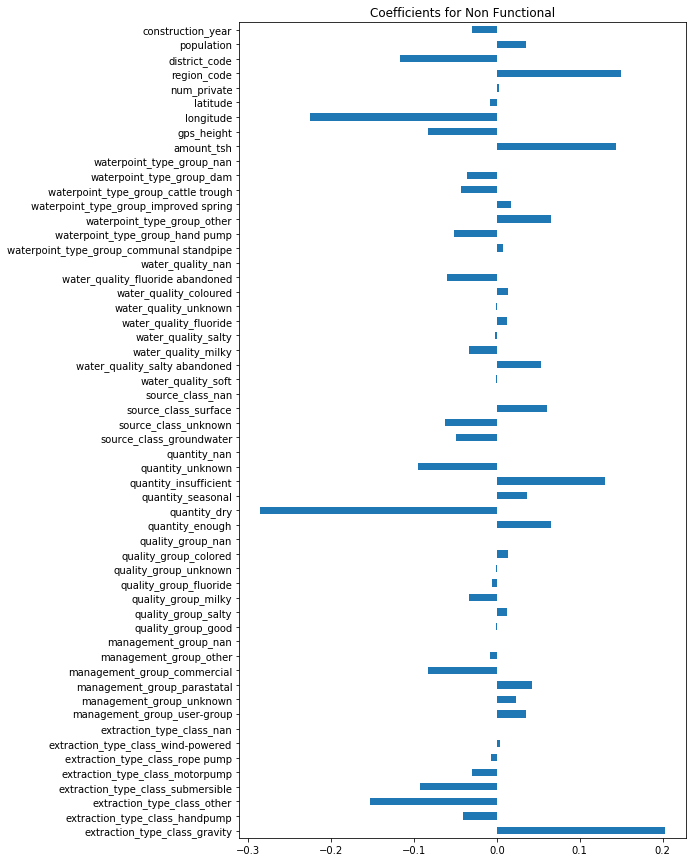

In [98]:
#Model Coefficients plotting for status non functional
fig = plt.figure(figsize=(8,15))
model_coefficients['non functional'].plot(kind='barh');
plt.title("Coefficients for Non Functional");

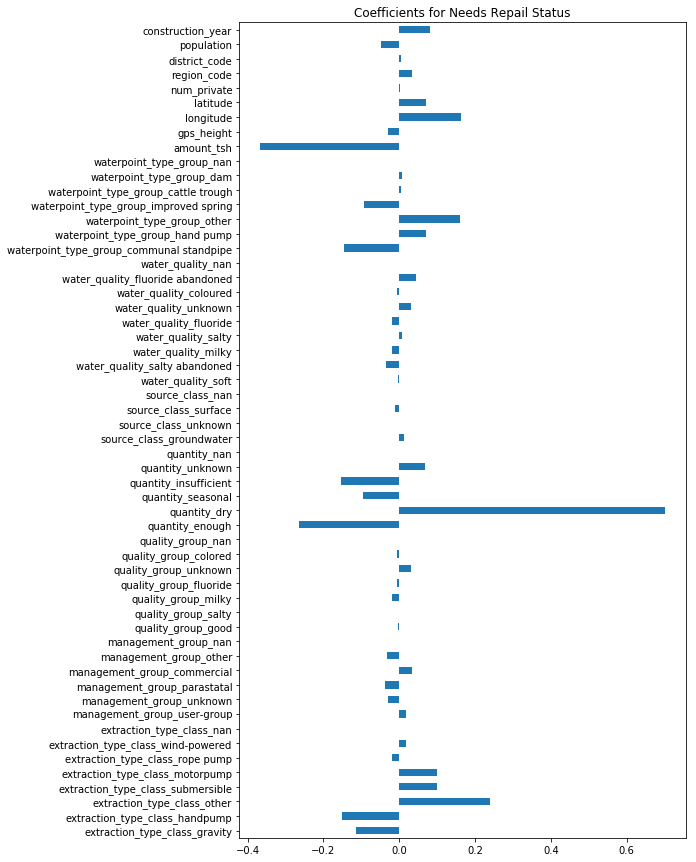

In [99]:
#Model Coefficients plotting for status functional needs repair
fig = plt.figure(figsize=(8,15))
model_coefficients['functional needs repair'].plot(kind='barh');
plt.title("Coefficients for Needs Repail Status");